In [23]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from torchsummary import summary
import random

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
train_data_dir = "./data/Cat_and_Dog/training_set/training_set"
test_data_dir = "./data/Cat_and_Dog/test_set/test_set"


In [4]:
class cats_dogs(Dataset):
  def __init__(self, folder):
    cats = glob(folder+'/cats/*.jpg')
    dogs = glob(folder+'/dogs/*.jpg')
    self.fpaths = cats + dogs
    from random import shuffle, seed; seed(10); shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # dog=1 & cat=0
  def __len__(self): 
    return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)

In [5]:
data = cats_dogs(train_data_dir)
im, label = data[20]

In [6]:
len(data)

8005

tensor([0.], device='cuda:0')


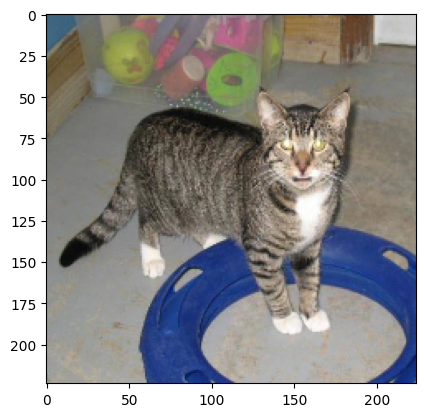

In [7]:
plt.imshow(im.permute(1, 2, 0).cpu())
print(label)

In [8]:
def conv_layer(ni, no, kernel_size, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, no, kernel_size, stride),
        nn.ReLU(),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2)
    )

In [9]:
def get_model():
    SNet = nn.Sequential(
        conv_layer(3, 64, 3),
        conv_layer(64, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        nn.Flatten(),
        nn.Linear(512, 1),
        nn.Sigmoid()
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(SNet.parameters(), lr=1e-3)
    return SNet, loss_fn, optimizer

In [10]:
SNet, loss_fn, optimizer = get_model()
summary(SNet, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  128
|    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-5                       295,424
|    └─ReLU: 2-6                         --
|    └─BatchNorm2d: 2-7                  1,024
|    └─MaxPool2d: 2-8                    --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-9                       2,359,808
|    └─ReLU: 2-10                        --
|    └─BatchNorm2d: 2-11                 1,024
|    └─MaxPool2d: 2-12                   --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-13                      2,359,808
|    └─ReLU: 2-14                        --
|    └─BatchNorm2d: 2-15                 1,024
|    └─MaxPool2d: 2-16                   --
├─Sequential: 1-5                      

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  128
|    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-5                       295,424
|    └─ReLU: 2-6                         --
|    └─BatchNorm2d: 2-7                  1,024
|    └─MaxPool2d: 2-8                    --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-9                       2,359,808
|    └─ReLU: 2-10                        --
|    └─BatchNorm2d: 2-11                 1,024
|    └─MaxPool2d: 2-12                   --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-13                      2,359,808
|    └─ReLU: 2-14                        --
|    └─BatchNorm2d: 2-15                 1,024
|    └─MaxPool2d: 2-16                   --
├─Sequential: 1-5                      

In [11]:
def train_batch(x, y, SNet, optimizer, loss_fn):
    prediction = SNet(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [12]:
@torch.no_grad()
def accuracy(x, y, SNet):
    prediction = SNet(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [13]:
def get_data():
    train = cats_dogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
    val = cats_dogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last=True)
    return trn_dl, val_dl

In [14]:
@torch.no_grad()
def val_loss(x, y, SNet):
    prediction = SNet(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [15]:
trn_dl, val_dl = get_data()
SNet, loss_fn, optimizer = get_model()

In [16]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(f"epoch: {epoch}")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_losses, val_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, SNet, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, SNet)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, SNet)
        validation_loss = val_loss(x, y, SNet)
        val_epoch_accuracies.extend(val_is_correct)
        val_epoch_losses.append(validation_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    val_epoch_loss = np.array(val_epoch_losses).mean()
    print(f"train_loss: {train_epoch_loss} val_loss: {val_epoch_loss}")
    print(f"train_accuracy: {train_epoch_accuracy}, val_accuracy: {val_epoch_accuracy}")
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

epoch: 0
train_loss: 0.6493523896932601 val_loss: 0.5145819882551829
train_accuracy: 0.747875, val_accuracy: 0.7544642857142857
epoch: 1
train_loss: 0.4836745903491974 val_loss: 0.40424659185939366
train_accuracy: 0.82975, val_accuracy: 0.8154761904761905
epoch: 2
train_loss: 0.3603192922770977 val_loss: 0.3111083668375772
train_accuracy: 0.887625, val_accuracy: 0.8616071428571429
epoch: 3
train_loss: 0.26312630814313887 val_loss: 0.33390265407543335
train_accuracy: 0.89525, val_accuracy: 0.8571428571428571
epoch: 4
train_loss: 0.21863311386108397 val_loss: 0.24300248838133282
train_accuracy: 0.9465, val_accuracy: 0.8983134920634921


In [18]:
train_accuracies, val_accuracies

([0.747875, 0.82975, 0.887625, 0.89525, 0.9465],
 [0.7544642857142857,
  0.8154761904761905,
  0.8616071428571429,
  0.8571428571428571,
  0.8983134920634921])

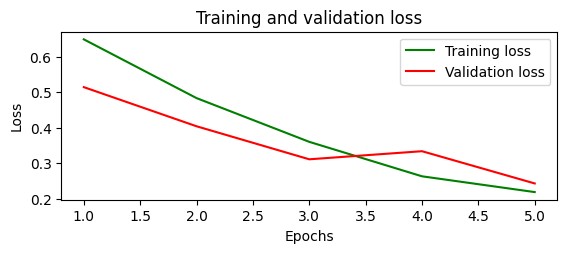

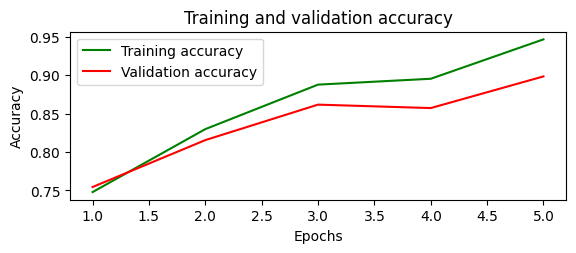

In [19]:
epochs = np.arange(5) + 1
plt.subplot(211)
plt.plot(epochs, train_losses, "g", label="Training loss")
plt.plot(epochs, val_losses, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.subplot(212)
plt.plot(epochs, train_accuracies, "g", label="Training accuracy")
plt.plot(epochs, val_accuracies, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

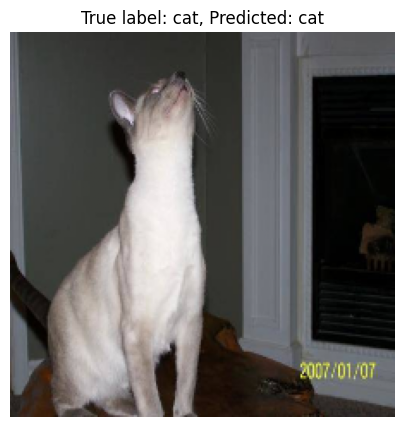

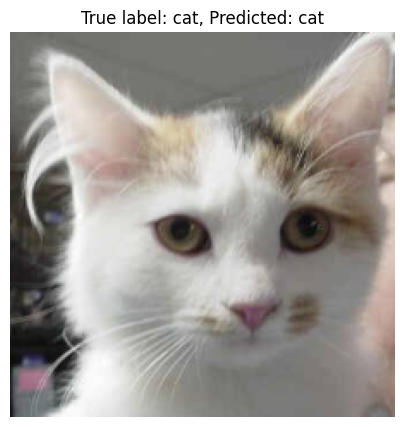

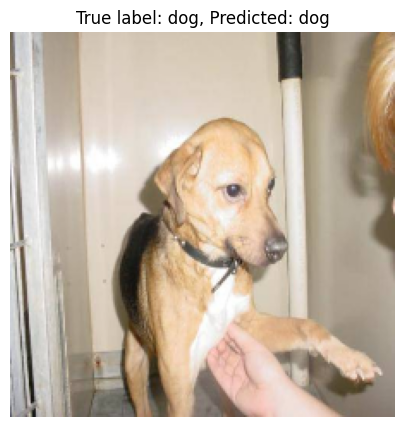

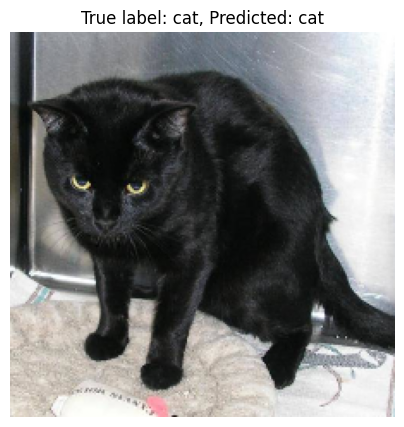

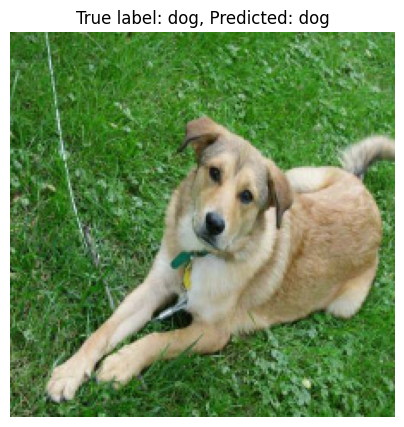

In [30]:
# Function to predict and compare the output
def predict_and_compare(SNet, dataset, device):
    # Set the model to evaluation mode
    SNet.eval()

    # We will go through the first 5 samples in the dataset for this demonstration
    for i in range(5):
        # Get the image and label
        img, label = dataset[i]
        
        # Move the image and label to the device (GPU/CPU)
        img = img.unsqueeze(0).to(device)  # Add batch dimension
        label = label.to(device)

        # Make the prediction
        with torch.no_grad():  # No need to track gradients
            prediction = SNet(img)

        # Convert the prediction to binary (dog or cat)
        predicted_label = (prediction > 0.5).float()
        
        # Convert the image back to the original shape (to plot)
        img = img.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert from Tensor to NumPy array
        #img = np.clip(img, 0, 1)  # Clip values to [0, 1]

        # Display the image and the prediction
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"True label: {'dog' if label.item() == 1 else 'cat'}, Predicted: {'dog' if predicted_label.item() == 1 else 'cat'}")
        plt.axis('off')
        plt.show()

# Example usage
train_data_dir = train_data_dir  
test_data_dir = test_data_dir   
train = cats_dogs(train_data_dir)
test = cats_dogs(test_data_dir)



# Example of prediction on a single image
predict_and_compare(SNet, test, device)